<a href="https://colab.research.google.com/github/AbdullahMakhdoom/Image-Search-Engine/blob/main/2-similarity_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective** 


*   Find the top 5 most similar images given a query imamge from Clatech101 dataset using the feature vectors generated in previous 'feature_extraction.ipynb' notebook.
*   Visualize the clusters of images  by reducing high-dimensional feature vectors to 2-D vectors using t-SNE algorithm.






Download Caltech101 for this jupyter notebook.

In [ ]:
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output caltech101.tar.gz
!tar -xvzf caltech101.tar.gz
!mkdir datasets
!mv 101_ObjectCategories datasets/caltech101
!rm -rf datasets/caltech101/BACKGROUND_Google # Removing 'BACKGROUND_Google' class directory

In [ ]:
import numpy as np
import pickle
from tqdm import tqdm, notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Mount Google Drive where we stored '.pickle' files' for Caltech101 features (simple as well as fine-tuned).Also load the filenames and class_ids.

In [ ]:
filenames = pickle.load(open('/content/drive/MyDrive/Caltech101-features/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('/content/drive/MyDrive/Caltech101-features/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('/content/drive/MyDrive/Caltech101-features/class_ids-caltech101.pickle', 'rb'))

num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)


Number of images =  8677
Number of features per image =  2048


## Nearest Neighbor
Using 'scikit-learn' for finding Nearest Neighbors to query images.

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm = 'brute',
                             metric = 'euclidean').fit(feature_list)
                        

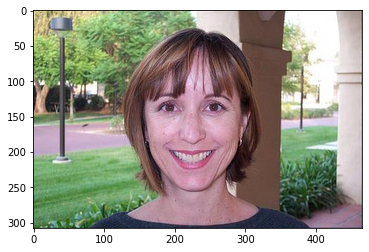

In [ ]:
random_index = 75
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

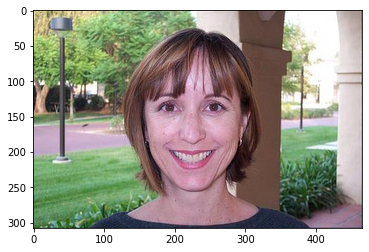

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]), interpolation='lanczos')

The nearest index is the image itself because that is what is being queired.
Plotting the 1st real nearest neighbors image.

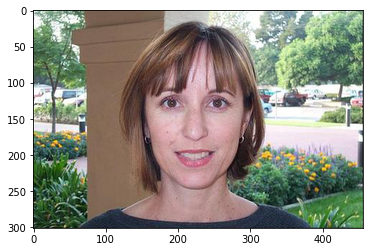

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')


In [ ]:
for i in range(5):
  print(distances[0][i])

5.1619136e-08
0.51936066
0.53159636
0.5465545
0.58122236


Note that the distance of the query feature vector to the first closest feature is close to zero, indicating that the closest image to the query image is the same image itself. 

In [ ]:
# Helper function to get the classname
def classname(str):
  return str.split('/')[-2]

# Helper function to get the classname and filename
def classname_filename(str):
  return str.split('/')[-2] + '/' + str.split('/')[-1]

# Helper functions to plot the nearest images given a query images
def plot_images(filenames, distances):
  images = []
  for filename in filenames:
    images.append(mpimg.imread(filename))
  plt.figure(figsize=(20,10))
  columns = 4
  for i, image in enumerate(images):
    ax = plt.subplot(len(images) / columns + 1, columns, i+1)
    if i == 0:
      ax.set_title("Query Image\n" + classname_filename(filenames[i]))
    else:
      ax.set_title("Similar Image\n" + classname_filename(filenames[i]) + 
                   "\nDistance" + str(float("{0:.2f}".format(distances[i]))))    
    plt.imshow(image)

Picking up query images randomly from the Caltech101 dataset and plotting top-3 most similar images present in the dataset.

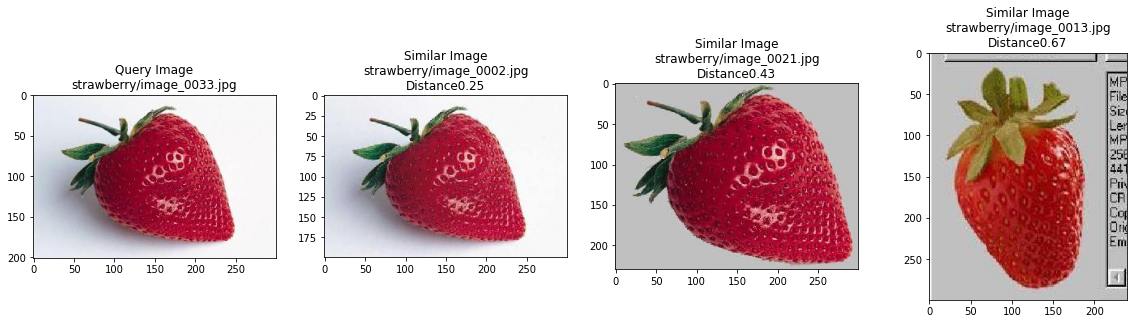

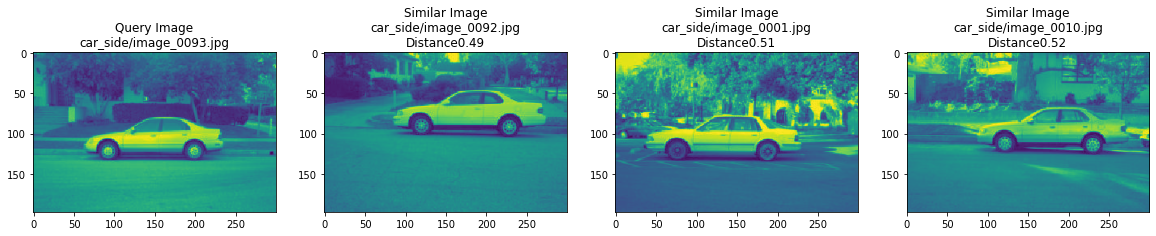

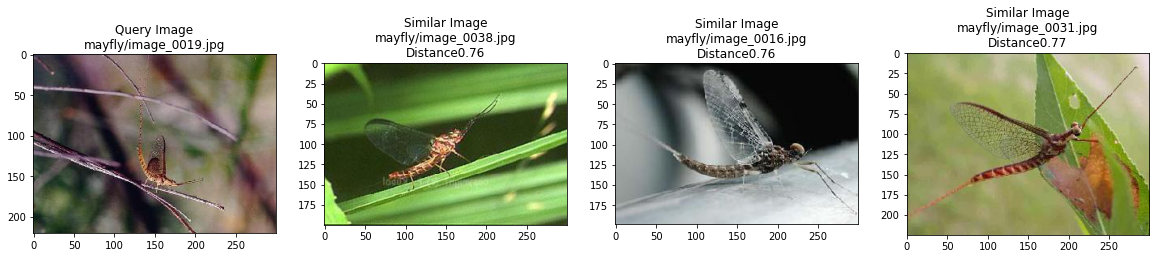

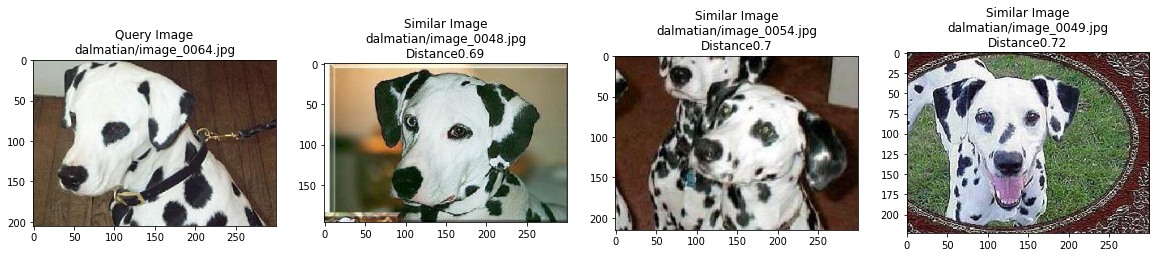

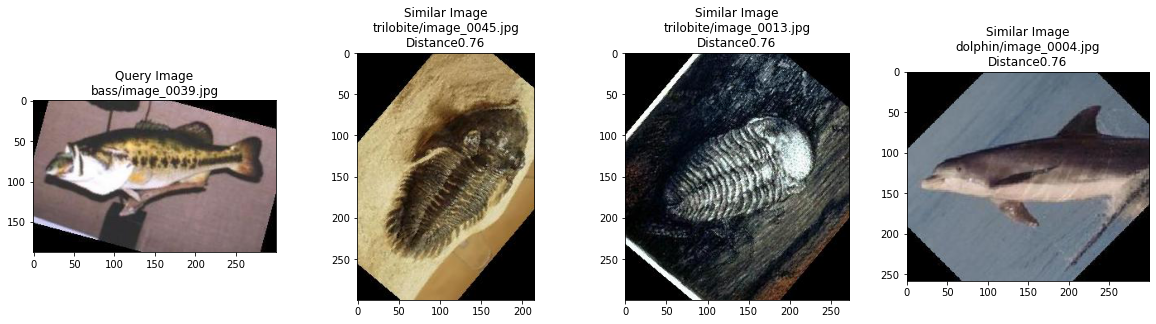

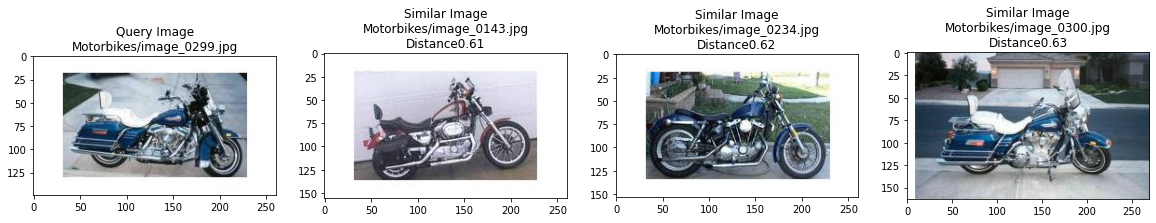

In [ ]:
for i in range(6):
  random_image_index = random.randint(0, num_images)
  distances, indices = neighbors.kneighbors(
      [feature_list[random_image_index]])
  # Not taking the first closest image since it is the same image
  similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1, 4)]
  plot_images(similar_image_paths, distances[0])


Getting a sense of similarity values by looking at distance stats over the dataset.

In [ ]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.0041637
Max distance between all photos:  1.2522099
Median distance among most similar photos:  0.65938926


## t-SNE Visulaization

In [ ]:
from sklearn.manifold import TSNE

time_start = time.time()
tsne_results = TSNE(n_components=2,
                    verbose = 1,
                    perplexity = 30,
                    n_iter = 1000,
                    metric = 'euclidean').fit_transform(feature_list)

print('t-SNE done. Time elapsed: {} seconds'.format(time.time()- time_start))                    
                  

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8677 samples in 3.734s...
[t-SNE] Computed neighbors for 8677 samples in 380.561s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8677
[t-SNE] Computed conditional probabilities for sample 2000 / 8677
[t-SNE] Computed conditional probabilities for sample 3000 / 8677
[t-SNE] Computed conditional probabilities for sample 4000 / 8677
[t-SNE] Computed conditional probabilities for sample 5000 / 8677
[t-SNE] Computed conditional probabilities for sample 6000 / 8677
[t-SNE] Computed conditional probabilities for sample 7000 / 8677
[t-SNE] Computed conditional probabilities for sample 8000 / 8677
[t-SNE] Computed conditional probabilities for sample 8677 / 8677
[t-SNE] Mean sigma: 0.196518
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.286400
[t-SNE] KL divergence after 1000 iterations: 1.287086
t-SNE done. Time elapsed: 448.6306998729706 seconds


Plotting a scatter plot from the generated t-SNE results.

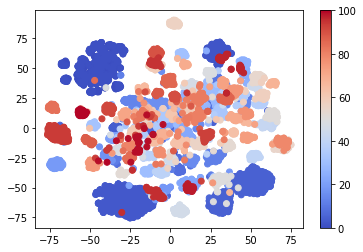

In [ ]:
color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=class_ids,
                           cmap = color_map)
plt.colorbar(scatter_plot)
plt.show()


Helper function to plot images in 2D for t-SNE.

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

Helper function to render a t-SNE plot.

In [ ]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.show()

Visualzing the clusters of the images formed by t-SNE

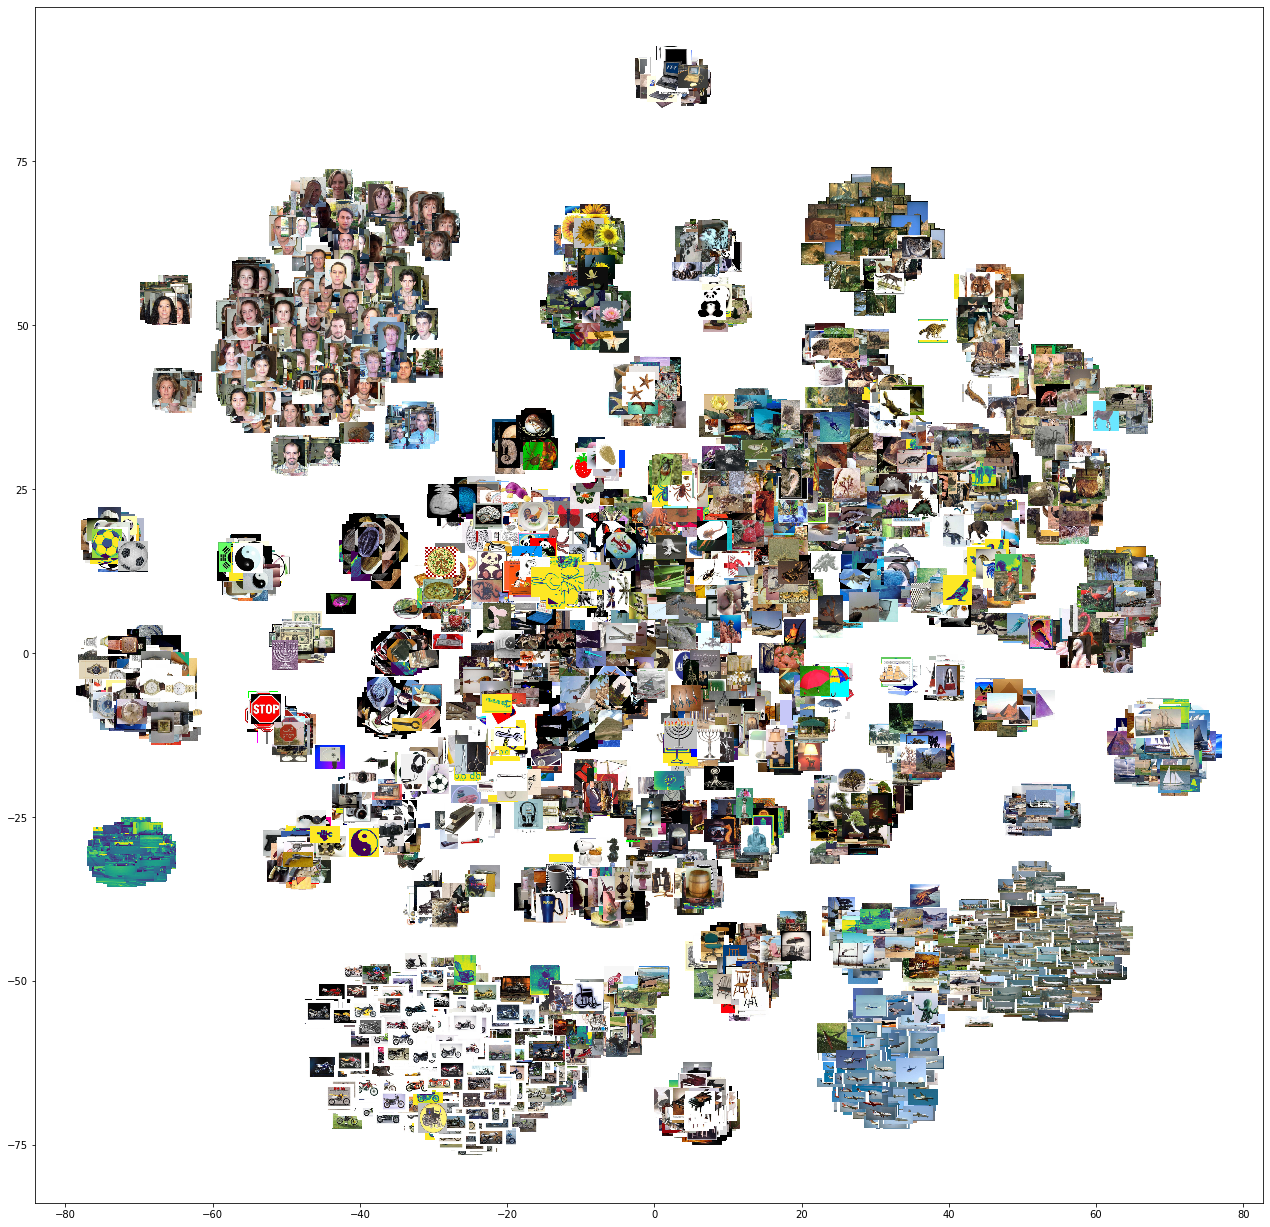

In [ ]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], filenames)

The `show_tsne` function piles images on top of each other, making it hard to discern the clusters as the density of images is high. 
 For better visualization, another helper function `tsne_to_grid_plotter_manual` that spaces the images evenly.




In [ ]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()

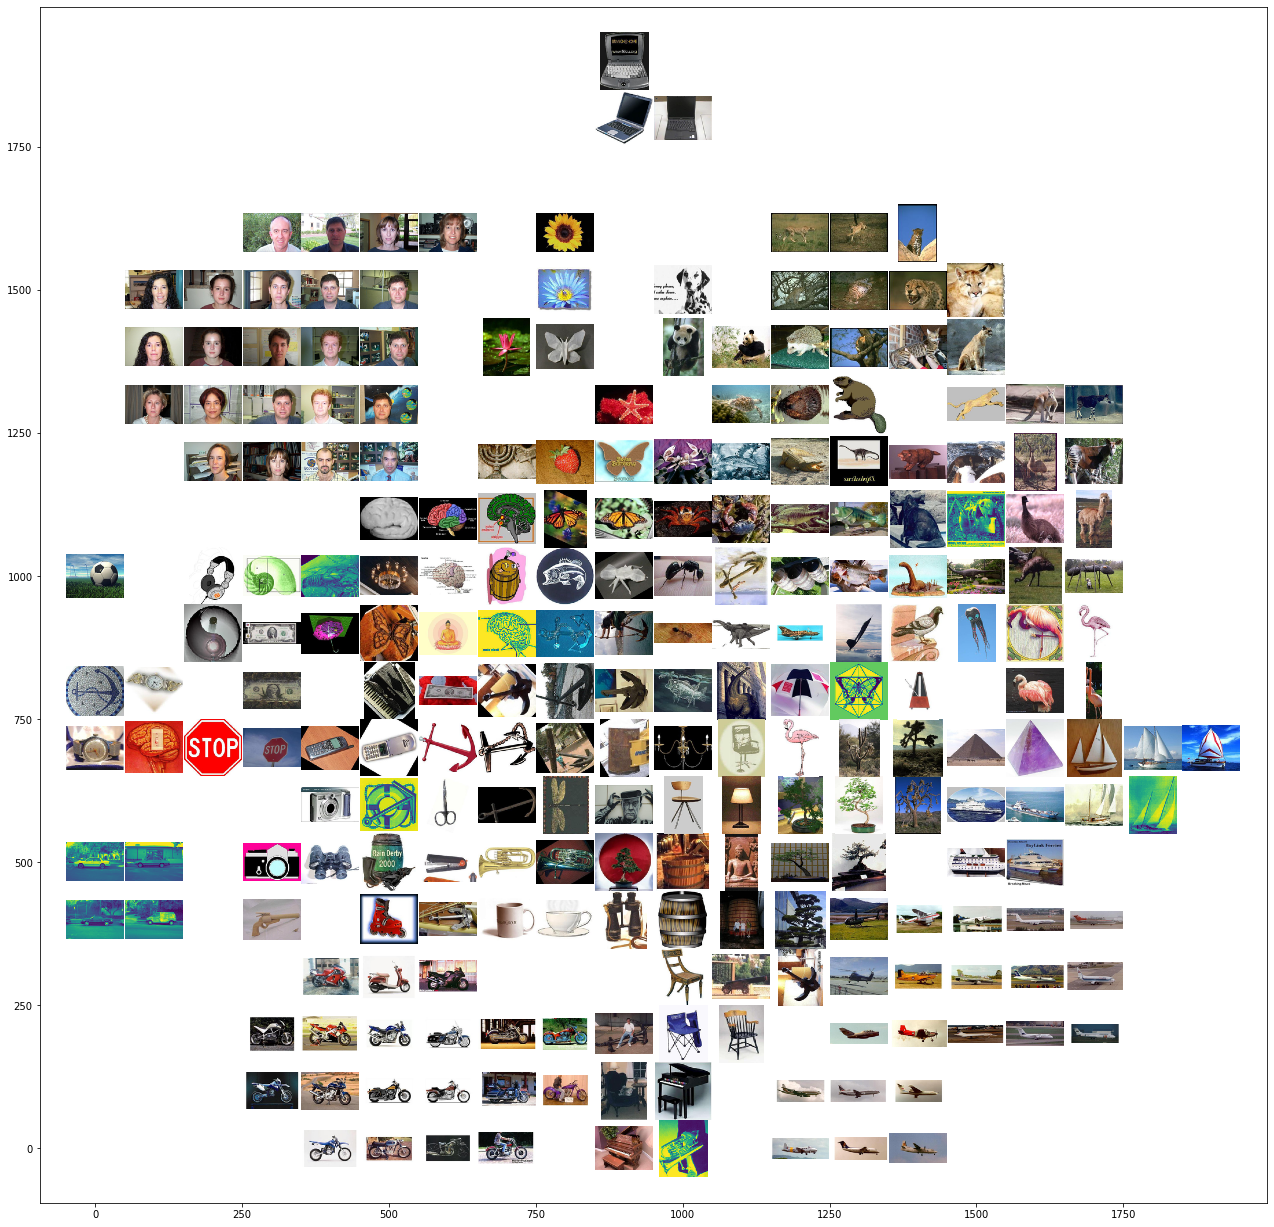

In [ ]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            filenames)